Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch

1. DATA LOADING & PREPARATION

In [2]:
# Load the specific dataset 
data_path = '../data/processed/model_ready/sugarcane_modeling.csv'
df = pd.read_csv(data_path)

print(f"Loaded Sugarcane Data: {len(df)} records")





# Feature Selection for Zoning
# We use Climate (Input) and Yield (Output) to find 'Potential Zones'
features = ['Avg_Temp', 'Total_Rainfall', 'Yield (Tonne/Hectare)']
X = df[features].copy()


# ==========================================
#  Why these features were considered for K-means?)
# ==========================================
print("-" * 40)
print("FEATURE SELECTION VALIDATION")
print("-" * 40)

# 1. Check Variance (We want high variance to distinguish districts)
print("Feature Variance (Raw Data):")
print(X.var())

# 2. Check Correlation (We want low correlation to avoid multicollinearity)
print("\nCorrelation Matrix (We want values closer to 0, not 1):")
corr_matrix = X.corr()
print(corr_matrix)

# Interpretation check
rain_temp_corr = corr_matrix.loc['Total_Rainfall', 'Avg_Temp']
print(f"\nCorrelation between Rain and Temp: {rain_temp_corr:.2f}")
if abs(rain_temp_corr) < 0.5:
    print("✅ VALID: Features are not strongly correlated. Safe for K-Means.")
else:
    print("⚠️ WARNING: High correlation detected.")


# Scaling (Standardization)
# Critical because Rainfall (1000+) dominates Temperature (25)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data scaled and ready for clustering.")

Loaded Sugarcane Data: 2942 records
----------------------------------------
FEATURE SELECTION VALIDATION
----------------------------------------
Feature Variance (Raw Data):
Avg_Temp                      6.489716
Total_Rainfall           629422.286119
Yield (Tonne/Hectare)      1206.885690
dtype: float64

Correlation Matrix (We want values closer to 0, not 1):
                       Avg_Temp  Total_Rainfall  Yield (Tonne/Hectare)
Avg_Temp               1.000000       -0.396146               0.304209
Total_Rainfall        -0.396146        1.000000              -0.284020
Yield (Tonne/Hectare)  0.304209       -0.284020               1.000000

Correlation between Rain and Temp: -0.40
✅ VALID: Features are not strongly correlated. Safe for K-Means.
Data scaled and ready for clustering.


 2. BASELINE MODEL: K-MEANS

----------------------------------------
BASELINE MODEL: K-MEANS CLUSTERING
----------------------------------------


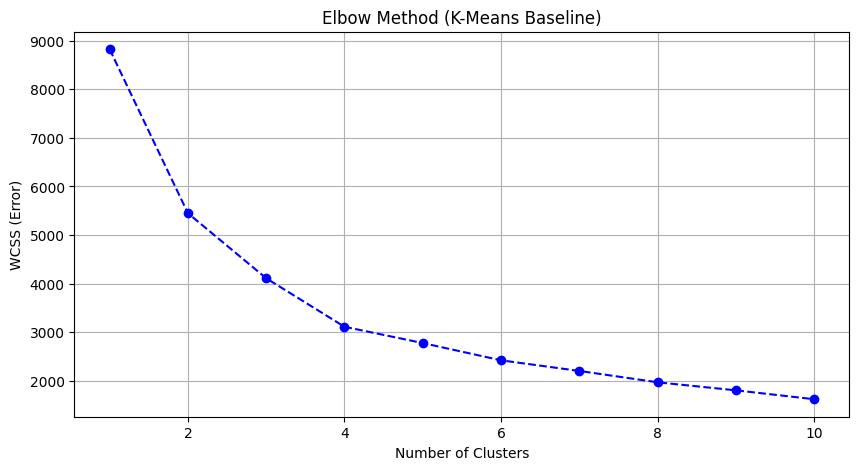

K-Means (K=3) Performance:
   Silhouette Score:     0.379 (Higher is better)
   Davies-Bouldin Index: 1.070 (Lower is better)


In [3]:

print("-" * 40)
print("BASELINE MODEL: K-MEANS CLUSTERING")
print("-" * 40)

# A. Elbow Method to find Optimal K
wcss = []
k_range = range(1, 11)

for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method (K-Means Baseline)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Error)')
plt.grid(True)
plt.show()

# B. Fit K-Means (Using K=3 based on Elbow)
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# C. Evaluate Baseline
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"K-Means (K={k_optimal}) Performance:")
print(f"   Silhouette Score:     {kmeans_sil:.3f} (Higher is better)")
print(f"   Davies-Bouldin Index: {kmeans_db:.3f} (Lower is better)")


3. PRIMARY MODEL: HIERARCHICAL CLUSTERING

----------------------------------------
PRIMARY MODEL: HIERARCHICAL CLUSTERING
----------------------------------------


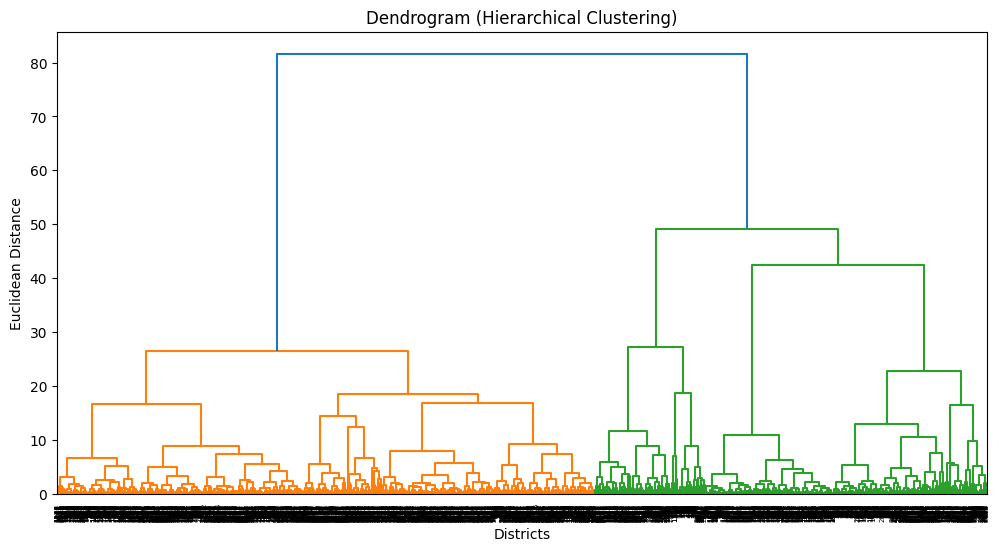

Hierarchical (K=3) Performance:
   Silhouette Score:     0.406
   Davies-Bouldin Index: 1.164


In [4]:
print("-" * 40)
print("PRIMARY MODEL: HIERARCHICAL CLUSTERING")
print("-" * 40)

# A. Dendrogram (To visualize hierarchy)
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram (Hierarchical Clustering)')
plt.xlabel('Districts')
plt.ylabel('Euclidean Distance')
plt.show()

# B. Fit Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
hc_labels = hc.fit_predict(X_scaled)

# C. Evaluate Primary Model
hc_sil = silhouette_score(X_scaled, hc_labels)
hc_db = davies_bouldin_score(X_scaled, hc_labels)

print(f"Hierarchical (K={k_optimal}) Performance:")
print(f"   Silhouette Score:     {hc_sil:.3f}")
print(f"   Davies-Bouldin Index: {hc_db:.3f}")


4. FINAL ZONING & VISUALIZATION

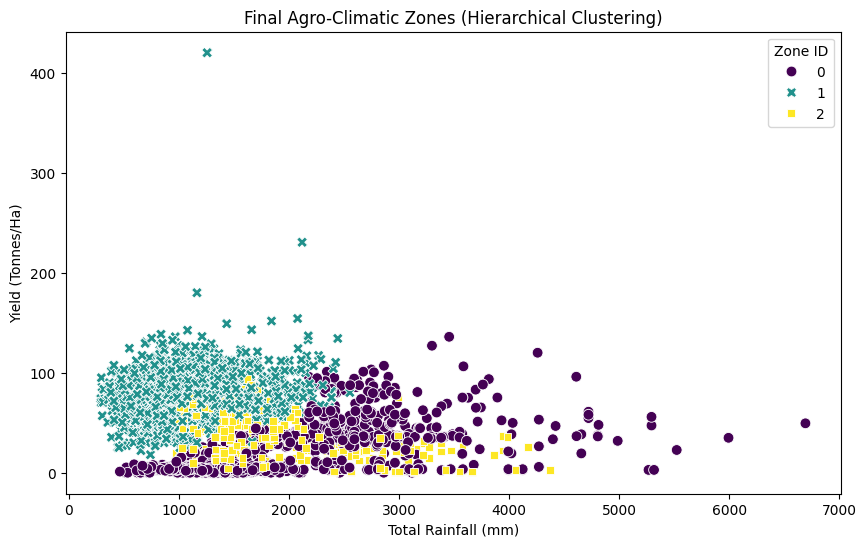

In [5]:

# We use the Hierarchical labels for the final recommendation
df['Cluster_ID'] = hc_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total_Rainfall', y='Yield (Tonne/Hectare)', 
                hue='Cluster_ID', palette='viridis', style='Cluster_ID', s=60)
plt.title('Final Agro-Climatic Zones (Hierarchical Clustering)')
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('Yield (Tonnes/Ha)')
plt.legend(title='Zone ID')
plt.show()


5. CLUSTER PROFILING (The "Business Logic")

In [8]:

print("-" * 40)
print("AGRO-CLIMATIC ZONE PROFILES")
print("-" * 40)

# Group by Cluster to see the characteristics
profile = df.groupby('Cluster_ID')[features].mean()
print(profile)

print("\nSTRATEGIC INTERPRETATION:")
# Automated logic to label the zones
max_yield_cluster = profile['Yield (Tonne/Hectare)'].idxmax()
min_yield_cluster = profile['Yield (Tonne/Hectare)'].idxmin()

for cluster_id in range(k_optimal):
    label = "MEDIUM RISK / MODERATE YIELD"
    if cluster_id == max_yield_cluster:
        label = "LOW RISK / HIGH YIELD (Ideal for Investment)"
    elif cluster_id == min_yield_cluster:
        label = "HIGH RISK / LOW YIELD (Requires Irrigation Support)"
        
    print(f"Zone {cluster_id}: {label}")
    print(f"   - Avg Rain: {profile.loc[cluster_id, 'Total_Rainfall']:.0f} mm")
    print(f"   - Avg Yield: {profile.loc[cluster_id, 'Yield (Tonne/Hectare)']:.1f} Tonnes/Ha")
    print("-" * 20)

----------------------------------------
AGRO-CLIMATIC ZONE PROFILES
----------------------------------------
             Avg_Temp  Total_Rainfall  Yield (Tonne/Hectare)
Cluster_ID                                                  
0           24.920275     1987.935309              23.872783
1           25.942780     1034.639612              78.121499
2           19.392752     1965.797800              33.922371

STRATEGIC INTERPRETATION:
Zone 0: HIGH RISK / LOW YIELD (Requires Irrigation Support)
   - Avg Rain: 1988 mm
   - Avg Yield: 23.9 Tonnes/Ha
--------------------
Zone 1: LOW RISK / HIGH YIELD (Ideal for Investment)
   - Avg Rain: 1035 mm
   - Avg Yield: 78.1 Tonnes/Ha
--------------------
Zone 2: MEDIUM RISK / MODERATE YIELD
   - Avg Rain: 1966 mm
   - Avg Yield: 33.9 Tonnes/Ha
--------------------
